In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('shopping_behavior_updated.csv')
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [3]:
# Mapping for categorical frequencies to numerical values
frequency_mapping = {
    "Weekly": 52,
    "Fortnightly": 26,
    "Bi-Weekly": 24,
    "Monthly": 12,
    "Every 3 Months": 4,
    "Quarterly": 4,
    "Annually": 1
}

# Apply the mapping
df["Frequency of Purchases (Numeric)"] = df["Frequency of Purchases"].map(frequency_mapping)

# Drop the original categorical column
df.drop(columns=["Frequency of Purchases"], inplace=True)

# Display updated dataset
print(df.head())

   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
1          Maine    L     Maroon  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Spring            2.7                 Yes   

   Shipping Type Discount Applied Promo Code Used  Previ

In [4]:
print(df["Frequency of Purchases (Numeric)"].unique())

[26 52  1  4 24 12]


In [6]:
# Create the required columns
df['Recency'] = df['Previous Purchases']
df['Frequency'] = df['Frequency of Purchases (Numeric)']
df['Monetary'] = df['Purchase Amount (USD)']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

In [8]:
# Monetary Value: Total Spend per Customer
df["Monetary"] = df.groupby("Customer ID")["Purchase Amount (USD)"].transform("sum")

# Loyalty Score: Higher frequency & subscription status = More Loyal
df["Loyalty_Score"] = df["Frequency of Purchases (Numeric)"] + df["Previous Purchases"]

# Loyalty score for subscribers with subscription status
df["Loyalty_Score"] += df["Subscription Status"].apply(lambda x: 10 if x.lower() == "subscribed" else 0)

In [10]:
scaler = MinMaxScaler()
df[["Frequency of Purchases (Numeric)", "Monetary", "Loyalty_Score"]] = scaler.fit_transform(df[["Frequency of Purchases (Numeric)", "Monetary", "Loyalty_Score"]])

# Display Updated Data
print(df[["Customer ID", "Frequency of Purchases (Numeric)", "Monetary", "Loyalty_Score"]].head())

   Customer ID  Frequency of Purchases (Numeric)  Monetary  Loyalty_Score
0            1                          0.490196    0.4125           0.38
1            2                          0.490196    0.5500           0.26
2            3                          1.000000    0.6625           0.73
3            4                          1.000000    0.8750           0.99
4            5                          0.000000    0.3625           0.30


In [11]:
# Ensure categorical "Subscription Status" is standardized
df["Subscription Status"] = df["Subscription Status"].str.lower().str.strip()

# Subscription Status: 1 for subscribed, 0 for non-subscribed
df["Subscription_Status_Binary"] = df["Subscription Status"].apply(lambda x: 1 if x == "subscribed" else 0)

# Engagement 
if "Review Rating" in df.columns:
    df["Engagement_Score"] = df["Review Rating"]
else:
    df["Engagement_Score"] = 0  # Default if missing

# Loyalty Score 
df["Loyalty_Score"] = df["Frequency of Purchases (Numeric)"] + df["Previous Purchases"] + (df["Subscription_Status_Binary"] * 10)

print(df.head())

   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  ...  Promo Code Used  \
0       Kentucky    L       Gray  Winter  ...              Yes   
1          Maine    L     Maroon  Winter  ...              Yes   
2  Massachusetts    S     Maroon  Spring  ...              Yes   
3   Rhode Island    M     Maroon  Spring  ...              Yes   
4         Oregon    M  Turquoise  Spring  ...              Yes   

  Previous Purchases Payment Method Frequency of Purchases (Numeric) Recency  \
0                 14          Venmo                   

In [13]:
%pip install sentence-transformers
%pip install tf-keras

from sentence_transformers import SentenceTransformer

# Pre-trained language model
model = SentenceTransformer('all-MiniLM-L6-v2')

df['Category_Embedding'] = df['Category'].apply(lambda x: model.encode(str(x)))
df['Item_Purchased_Embedding'] = df['Item Purchased'].apply(lambda x: model.encode(str(x)))

# Convert embeddings to NumPy arrays
category_embeddings = np.vstack(df['Category_Embedding'].values)
item_purchased_embeddings = np.vstack(df['Item_Purchased_Embedding'].values)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [18]:
# PCA to reduce dimensionality before clustering
pca = PCA(n_components=4)  
X_pca = pca.fit_transform(category_embeddings)

In [22]:
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance: {explained_variance * 100:.2f}%")


Explained variance: 100.00%


In [23]:
# Reduce dimensionality using PCA
pca = PCA(n_components=20)  
category_embeddings_pca = pca.fit_transform(category_embeddings)
item_purchased_embeddings_pca = pca.fit_transform(item_purchased_embeddings)

# Concatenate PCA-reduced embeddings
X_embeddings = np.concatenate([category_embeddings_pca, item_purchased_embeddings_pca], axis=1)

# Display shape of concatenated embeddings
print(X_embeddings.shape)

(3900, 40)


In [ ]:
# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_embeddings)
df['Cluster'] = kmeans.labels_

# Cluster centers
cluster_centers = kmeans.cluster_centers_
print(cluster_centers)

[[ 6.18267238e-01  2.71028653e-02  1.15340492e-02  1.40666962e-05
  -1.37369938e-08  2.15950955e-08 -3.10828980e-08  3.72529563e-09
   5.37838751e-08  6.44648956e-09 -8.87670382e-10 -1.38534286e-08
  -7.68341035e-09  1.48038506e-08 -3.70200794e-08 -2.50292835e-08
   2.82889250e-08 -2.71247682e-08 -3.60887427e-08 -1.80443784e-08
   1.10803135e-02  3.74437928e-01 -8.92258584e-02 -2.45943680e-01
   1.14700329e-02  1.23984911e-01  1.04269199e-01 -1.07184738e-01
  -1.56841427e-02 -8.17748830e-02 -6.70807064e-02  9.91205405e-03
   7.93806650e-03 -4.13148738e-02 -2.53954809e-02  3.40703875e-02
  -2.11054888e-02  3.77307609e-02 -1.02689162e-01 -1.85790714e-02]
 [-3.57413977e-01  6.01985157e-01  1.90408781e-01  2.80141758e-05
  -1.58092064e-07 -1.49768240e-07  9.74395675e-08 -8.33534060e-08
   6.21657890e-08  1.25655845e-07 -1.51761881e-07  1.16531702e-07
   3.28291172e-08  6.69578455e-08  5.98375038e-08  3.45753541e-08
  -2.38651392e-08 -4.66825405e-08 -8.63801830e-08 -8.23056041e-08
   4.4537

In [29]:
#Silhouette Score for K-Means
silhouette_score_kmeans = silhouette_score(X_embeddings, kmeans.labels_)
print(f"Silhouette Score: {silhouette_score_kmeans:.2f}")

# Flatten the cluster centers array
flattened_cluster_centers = cluster_centers.flatten()

# Final clustering results
clustering_results = {
    "Silhouette Score": [silhouette_score_kmeans],
    "Cluster Centers": [flattened_cluster_centers]
}

# Convert results to DataFrame and display
df_clustering_results = pd.DataFrame(clustering_results)
print(df_clustering_results)

Silhouette Score: 0.33
   Silhouette Score                                    Cluster Centers
0          0.327589  [0.61826724, 0.027102865, 0.011534049, 1.40666...


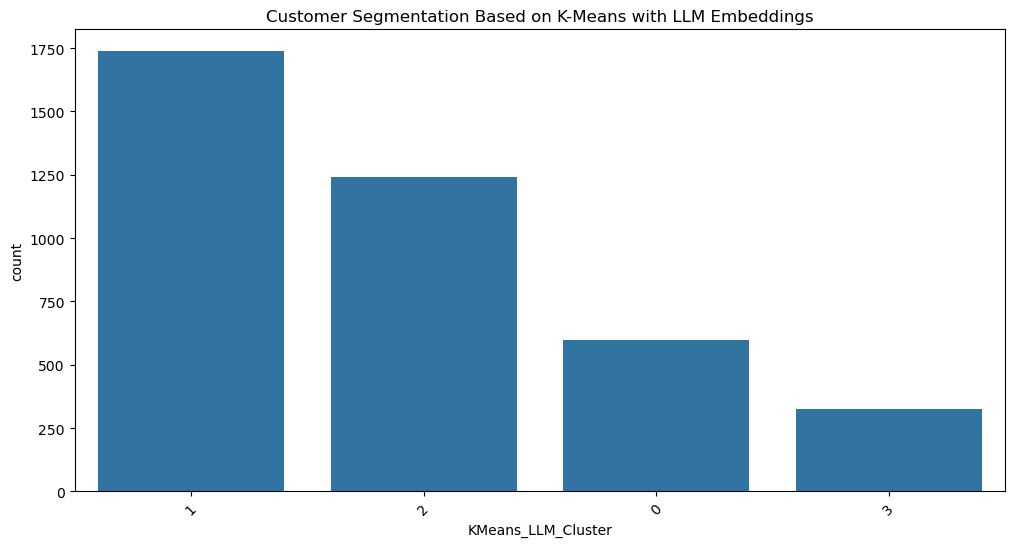

In [30]:
plt.figure(figsize=(12, 6))
sns.countplot(x="KMeans_LLM_Cluster", data=df, order=df["KMeans_LLM_Cluster"].value_counts().index)
plt.title("Customer Segmentation Based on K-Means with LLM Embeddings")
plt.xticks(rotation=45)
plt.show()

In [35]:
# Define clusters & metrics
numeric_columns = df.select_dtypes(include=[np.number]).columns
cluster_means_llm = df.groupby("KMeans_LLM_Cluster")[numeric_columns].mean()
print(cluster_means_llm)

# Number of variables
categories = list(cluster_means_llm.columns)
N = len(categories)

# Convert to radar chart format
values = cluster_means_llm.values
cluster_names = [f'Cluster {i}' for i in range(len(cluster_means_llm))]
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()


                    Customer ID        Age  Purchase Amount (USD)  \
KMeans_LLM_Cluster                                                  
0                   1959.759599  44.442404              60.255426   
1                   1958.939551  43.782959              60.025331   
2                   1945.501613  44.224194              59.838710   
3                   1907.265432  44.311728              57.172840   

                    Review Rating  Previous Purchases  \
KMeans_LLM_Cluster                                      
0                        3.790651           25.232053   
1                        3.723143           25.199194   
2                        3.768629           25.725806   
3                        3.746914           24.956790   

                    Frequency of Purchases (Numeric)    Recency  Frequency  \
KMeans_LLM_Cluster                                                           
0                                           0.326557  25.232053  17.654424   
1       

In [37]:
from sentence_transformers import SentenceTransformer

# Sentence embedding model 
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Categorical/text columns to convert into embeddings
text_columns = ["Category", "Subscription Status", "Payment Method"]

# Categorical values into embeddings
def encode_text_features(df, columns):
    text_data = df[columns].astype(str).agg(" ".join, axis=1)  # Concatenate selected text features
    embeddings = embedder.encode(text_data, convert_to_numpy=True)  # Generate text embeddings
    return embeddings

# Text embeddings
text_embeddings = encode_text_features(df, text_columns)

# Stack with numerical features for clustering
numerical_features = ["Recency", "Frequency", "Monetary", "Engagement_Score"]
X_combined = np.hstack((df[numerical_features].values, text_embeddings))

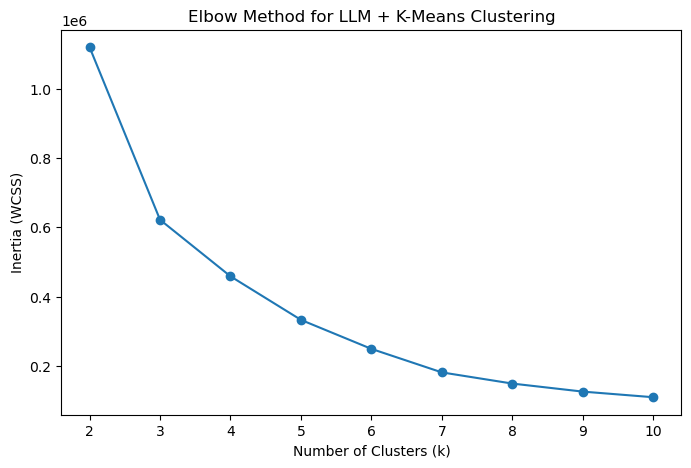

Silhouette Score (LLM + K-Means): 0.4544503663566674
Davies-Bouldin Index (LLM + K-Means): 0.7822053369796621


In [38]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Determine the optimal number of clusters (Elbow Method)
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for LLM + K-Means Clustering")
plt.show()

# Choose optimal number of clusters
optimal_k_llm = 4  # Adjust based on elbow method

# Apply K-Means with chosen k
kmeans_llm = KMeans(n_clusters=optimal_k_llm, random_state=42, n_init=10)
df["LLM_KMeans_Cluster"] = kmeans_llm.fit_predict(X_combined)

# Evaluate clustering quality
silhouette_llm = silhouette_score(X_combined, df["LLM_KMeans_Cluster"])
davies_bouldin_llm = davies_bouldin_score(X_combined, df["LLM_KMeans_Cluster"])

# Display evaluation results
print("Silhouette Score (LLM + K-Means):", silhouette_llm)
print("Davies-Bouldin Index (LLM + K-Means):", davies_bouldin_llm)

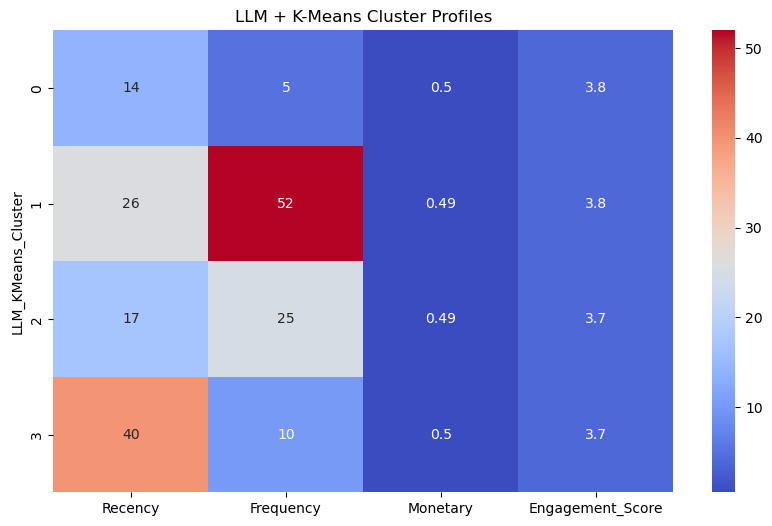

In [39]:
# Compute mean values for numerical features per cluster
cluster_means_llm = df.groupby("LLM_KMeans_Cluster")[numerical_features].mean()

# Heatmap of cluster profiles
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_llm, annot=True, cmap="coolwarm")
plt.title("LLM + K-Means Cluster Profiles")
plt.show()